# GOAL

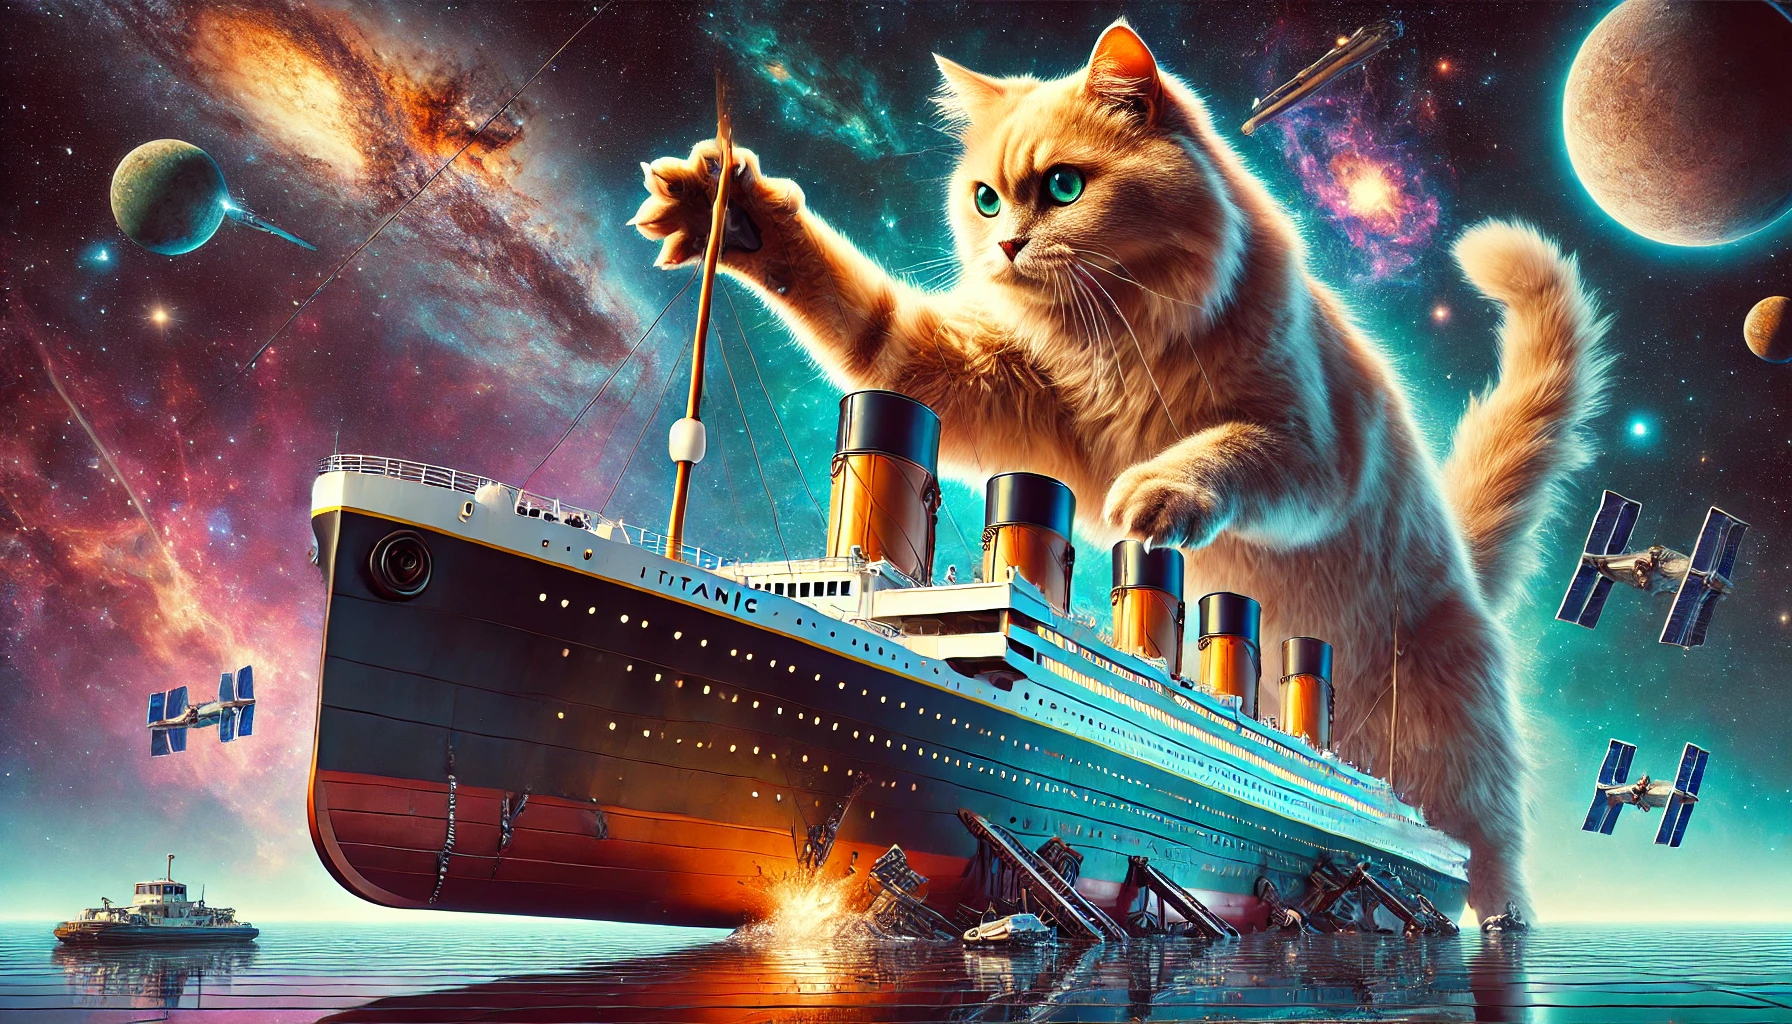

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

# Dependencies import

In [ ]:
!pip install --no-warn-conflicts -q skrub~=0.3.1
!pip install --no-warn-conflicts -q scikit-learn~=1.5.2
!pip install feature-engine
!pip install catboost
!pip install category_encoders
!pip install shap
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Dependencies

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [ ]:
import sklearn
import skrub
from skrub import TableReport

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from sklearn.impute import SimpleImputer

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [22]:
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [26]:
from category_encoders import CatBoostEncoder
from catboost import CatBoostClassifier

In [28]:
from feature_engine.creation import MathFeatures, RelativeFeatures
from feature_engine.pipeline import make_pipeline

# Data

In [30]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [32]:
TableReport(train_df)

Processing column  13 / 13


,,,,,,,,,,,,,


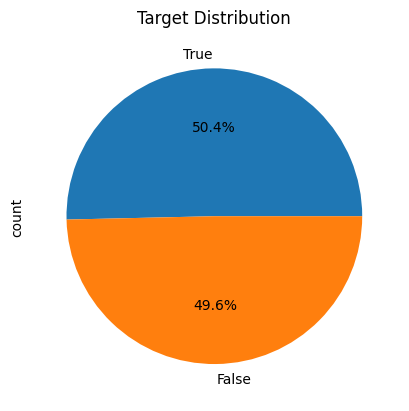

In [34]:
train_df["Transported"] = train_df["Transported"]
train_df["Transported"].value_counts().plot.pie(autopct="%.1f%%")
plt.title("Target Distribution");

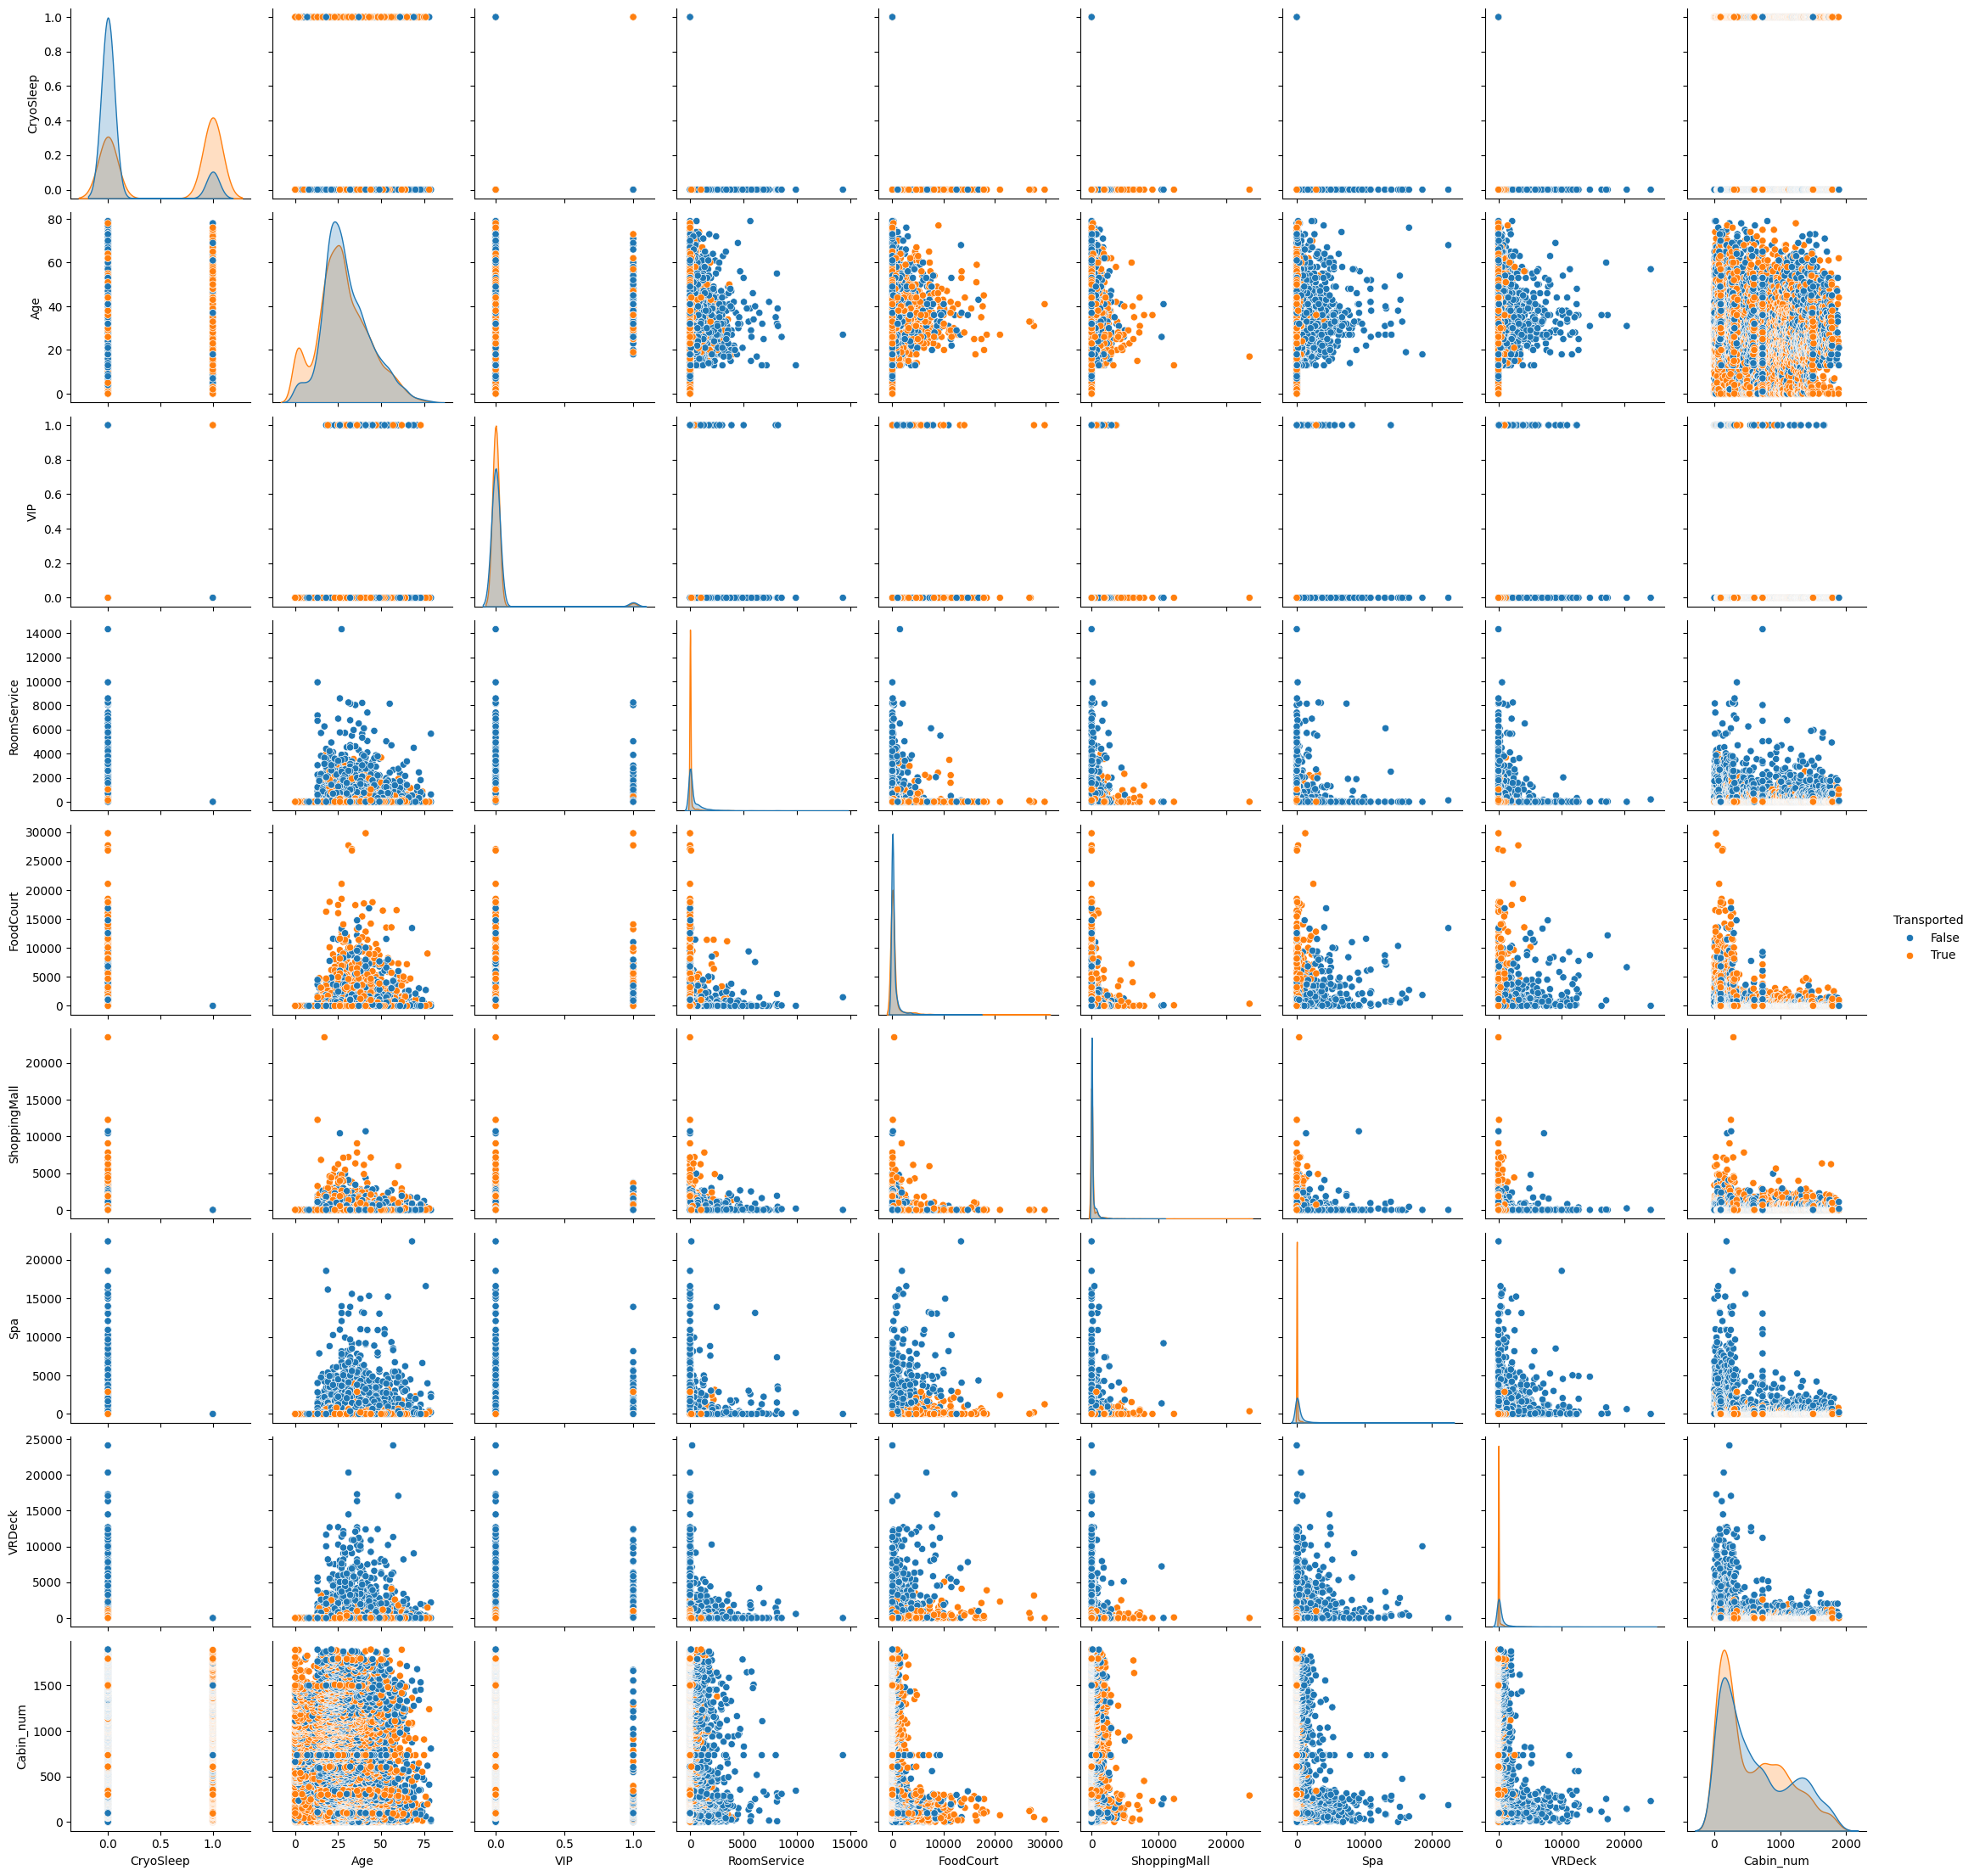

In [36]:
sns.pairplot(data=train_df, hue="Transported");

In [38]:
def percent_missing(df):
  """ Displays the percentage of missing values in the columns """
  res = 100 * df.isnull().sum() / len(df)
  res = res[res > 0].sort_values()
  return res

percent_missing(train_df)

Series([], dtype: float64)

In [40]:
def print_uniq(type):
  """ Outputs unique values in the column """
  obj_col = train_df.select_dtypes(include=type).columns

  print(f"🔍 {type.upper()}:")
  for col in obj_col:
    print(f'{col}: {train_df[col].unique()}')

In [42]:
print_uniq('object')
print_uniq('float')

🔍 OBJECT:
HomePlanet: ['Europa' 'Earth' 'Mars']
CryoSleep: [False True]
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
VIP: [False True]
Deck: ['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
Side: ['P' 'S']
🔍 FLOAT:
RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Spa: [   0.  549. 6715. ... 2868. 1107. 1643.]
VRDeck: [   0.   44.   49. ... 1164.  971. 3235.]


In [44]:
def preprocess_data(df):
    """ This function preprocesses a DataFrame by performing the following steps:

    1. Handles missing values:
        - For numerical columns, missing values are filled with the median.
        - For categorical columns, missing values are filled with the most frequent value.

    2. Splits the "Cabin" column (if it exists) into three new columns: "Deck", "Cabin_num", and "Side".

    3. Drops unnecessary columns:
        - Specifically drops the "Name" column if it exists.

    4. Converts data types:
        - Converts the "Age" column to integer type (if it exists).
        - Converts the "Cabin_num" column to integer type (if it exists).
    """

    num_columns = df.select_dtypes(include=["number"]).columns
    cat_columns = df.select_dtypes(include=["object"]).columns

    for col in num_columns:
        si = SimpleImputer(strategy="median")
        df[col] = pd.Series(si.fit_transform(df[[col]]).flatten(), index=df.index)

    for col in cat_columns:
        si = SimpleImputer(strategy="most_frequent")
        df[col] = pd.Series(si.fit_transform(df[[col]]).flatten(), index=df.index)

    if "Cabin" in df.columns:
        df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)

    columns_to_drop = ["Name", "Cabin"]
    df = df.drop(columns=columns_to_drop, errors="ignore")

    if "Age" in df.columns:
        df["Age"] = df["Age"].astype(int)
    if "Cabin_num" in df.columns:
        df["Cabin_num"] = df["Cabin_num"].astype(int)

    return df


In [46]:
train_df = preprocess_data(train_df)

# Modeling

In [48]:
X, y = train_df.drop(columns="Transported"), train_df["Transported"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=101)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 13), (1739, 13), (6954,), (1739,))

## Transforming Categorical Data for Machine Learning Models

In [50]:
def order_and_scale_features(X_, ordinal_encoder=None, scaler=None, is_train=True):
  """
  Transforms the input data by separating it into categorical and numeric attributes.Categorical
  attributes are encoded using OrdinalEncoder, and numeric attributes are scaled using RobustScaler.
  are scaled using RobustScaler.
  """
  num_fea = ['Age', 'Cabin_num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  cat_fea = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP']

  if is_train:
      ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      scaler = RobustScaler(with_centering=True)

      X_cat = pd.DataFrame(
          ordinal_encoder.fit_transform(X_[cat_fea]),
          columns=cat_fea,
          index=X_.index
      )
      X_num = pd.DataFrame(
          scaler.fit_transform(X_[num_fea]),
          columns=num_fea,
          index=X_.index
      )
  else:
      X_cat = pd.DataFrame(
          ordinal_encoder.transform(X_[cat_fea]),
          columns=cat_fea,
          index=X_.index
      )
      X_num = pd.DataFrame(
          scaler.transform(X_[num_fea]),
          columns=num_fea,
          index=X_.index
      )

  X_processed = pd.concat([X_cat, X_num], axis=1)

  if is_train:
      return X_processed, ordinal_encoder, scaler
  else:
      return X_processed

In [52]:
X_train_final, ordinal_encoder, scaler = order_and_scale_features(X_train)

X_val_final = order_and_scale_features(X_val, ordinal_encoder=ordinal_encoder, scaler=scaler, is_train=False)

In [54]:
def print_roc_auc(model, X_, y_, title="ROC-AUC"):
    """Calculates and prints score."""
    y_pred = model.predict_proba(X_)[:, 1]
    score = roc_auc_score(y_, y_pred)
    y_pred_classes = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_, y_pred_classes)
    clsr = classification_report(y_, y_pred_classes)
    print("clsr: ", clsr)
    print(f"{title}: {score:.6f}")
    print(f"Accuracy: {acc:.6f}")

## Decision Tree Ensembles

In [56]:
random_forest = RandomForestClassifier(
    n_estimators=200,
    max_features='sqrt',
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42)
random_forest.fit(X_train_final, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, random_state=42)

In [58]:
print_roc_auc(random_forest, X_train_final, y_train, title="Baseline ROC-AUC (Train)")
print_roc_auc(random_forest, X_val_final, y_val, title="Baseline ROC-AUC (Valid)")

clsr:                precision    recall  f1-score   support

       False       0.96      0.96      0.96      3438
        True       0.97      0.96      0.96      3516

    accuracy                           0.96      6954
   macro avg       0.96      0.96      0.96      6954
weighted avg       0.96      0.96      0.96      6954

Baseline ROC-AUC (Train): 0.995339
Accuracy: 0.960742
clsr:                precision    recall  f1-score   support

       False       0.82      0.83      0.82       877
        True       0.82      0.81      0.82       862

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Baseline ROC-AUC (Valid): 0.904980
Accuracy: 0.820012


## Building a Simple Classification Model Using CatBoost

In [60]:
cgbdt = CatBoostClassifier(
    iterations=200,
    learning_rate=0.2,
    random_seed=42,
    verbose=200,
    l2_leaf_reg=7
)
cgbdt.fit(X_train_final, y_train)

0:	learn: 0.6140609	total: 2.53ms	remaining: 503ms
199:	learn: 0.2605633	total: 232ms	remaining: 0us


In [61]:
print_roc_auc(cgbdt, X_train_final, y_train, title="Baseline ROC-AUC (Train)")
print_roc_auc(cgbdt, X_val_final, y_val, title="Baseline ROC-AUC (Valid)")

clsr:                precision    recall  f1-score   support

       False       0.90      0.88      0.89      3438
        True       0.89      0.90      0.89      3516

    accuracy                           0.89      6954
   macro avg       0.89      0.89      0.89      6954
weighted avg       0.89      0.89      0.89      6954

Baseline ROC-AUC (Train): 0.966195
Accuracy: 0.892580
clsr:                precision    recall  f1-score   support

       False       0.84      0.81      0.82       877
        True       0.81      0.84      0.83       862

    accuracy                           0.83      1739
   macro avg       0.83      0.83      0.83      1739
weighted avg       0.83      0.83      0.83      1739

Baseline ROC-AUC (Valid): 0.910624
Accuracy: 0.825187


## Significance analysis of attributes using SHAP

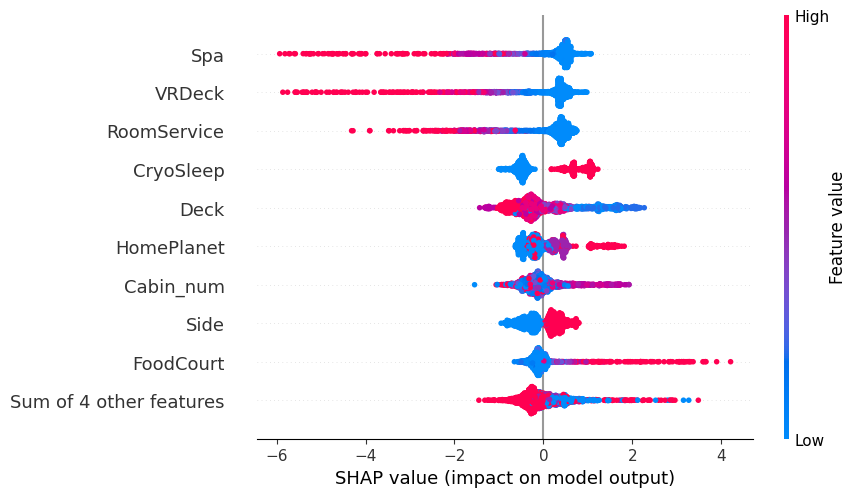

In [62]:
explainer = shap.Explainer(cgbdt)
shap_values = explainer(X_val_final)
shap.plots.beeswarm(shap_values)

# Training on test data and recording the results

In [63]:
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: float64(6), object(6)
memory usage: 434.4+ KB


In [64]:
test_df = preprocess_data(test_df)

In [68]:
X_test_final = order_and_scale_features(test_df, ordinal_encoder=ordinal_encoder, scaler=scaler, is_train=False)

In [84]:
y_pred = cgbdt.predict(X_test_final).astype(bool)
submission_df = pd.read_csv("data/sample_submission.csv")
submission_df["Transported"] = y_pred
submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [91]:
submission_df.to_csv("data/submission.csv", index=False)
!head -n 6 submission.csv

head: невозможно открыть 'submission.csv' для чтения: Нет такого файла или каталога
